In [1]:
import pandas as pd
tweets = pd.read_csv("/home/ailabguest/alessandrodileone/dataset_sentiment/train.csv", encoding='latin-1')
list(tweets.columns.values)

['ItemID', 'Sentiment', 'SentimentText']

In [2]:
tweets.Sentiment.replace(0,'negative', inplace=True)
tweets.Sentiment.replace(1,'positive', inplace=True)

In [3]:
tweets.head()

,ItemID,Sentiment,SentimentText
54142,54154,negative,@Austinslide sort of..... its called work....
57041,57053,positive,@basedmagazine good morning! everything is ble...
3803,3804,positive,Kicking it with Genesis. Being dramatic. Watc...
16891,16903,negative,;gives up... I guess there's no hope for getti...
72635,72647,positive,"@cameronmstewart awesome comic, can't wait for..."


In [4]:
sentiment_counts = tweets.Sentiment.value_counts()
number_of_tweets = tweets.ItemID.count()
print(sentiment_counts)

positive    5634
negative    4365
Name: Sentiment, dtype: int64


In [5]:
import re, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(tweet):
    only_letters = re.sub("[^a-zA-Z]", " ",tweet) 
    tokens = nltk.word_tokenize(only_letters)[2:]
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [6]:
normalizer("Here is text about an airline I like.")

['text', 'airline', 'like']

In [7]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
tweets['normalized_tweet'] = tweets.SentimentText.apply(normalizer)
tweets[['SentimentText','normalized_tweet']].head()

,SentimentText,normalized_tweet
54142,@Austinslide sort of..... its called work....,"[called, work]"
57041,@basedmagazine good morning! everything is blessed..... sure,"[morning, everything, blessed, sure]"
3803,Kicking it with Genesis. Being dramatic. Watching a chick flick. This is highly entertaining surprisingly.,"[genesis, dramatic, watching, chick, flick, highly, entertaining, surprisingly]"
16891,;gives up... I guess there's no hope for getting the iPhone 3.0 update while I'm awake,"[guess, hope, getting, iphone, update, awake]"
72635,"@cameronmstewart awesome comic, can't wait for more saw it in andy diggle's tweets something was different about it, in a good way","[comic, wait, saw, andy, diggle, tweet, something, different, good, way]"


In [8]:
from nltk import ngrams
def ngrams(input_list):
    #onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
    trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return bigrams+trigrams
tweets['grams'] = tweets.normalized_tweet.apply(ngrams)
tweets[['grams']].head()

,grams
54142,[called work]
57041,"[morning everything, everything blessed, blessed sure, morning everything blessed, everything blessed sure]"
3803,"[genesis dramatic, dramatic watching, watching chick, chick flick, flick highly, highly entertaining, entertaining surprisingly, genesis dramatic watching, dramatic watching chick, watching chick flick, chick flick highly, flick highly entertaining, highly entertaining surprisingly]"
16891,"[guess hope, hope getting, getting iphone, iphone update, update awake, guess hope getting, hope getting iphone, getting iphone update, iphone update awake]"
72635,"[comic wait, wait saw, saw andy, andy diggle, diggle tweet, tweet something, something different, different good, good way, comic wait saw, wait saw andy, saw andy diggle, andy diggle tweet, diggle tweet something, tweet something different, something different good, different good way]"


In [9]:
import collections
def count_words(input):
    cnt = collections.Counter()
    for row in input:
        for word in row:
            cnt[word] += 1
    return cnt

In [10]:
tweets[(tweets.Sentiment == 'negative')][['grams']].apply(count_words)['grams'].most_common(20)

[('gon na', 61),
 ('wan na', 47),
 ('wish could', 34),
 ('bit ly', 27),
 ('sorry hear', 25),
 ('want go', 25),
 ('http bit', 24),
 ('http bit ly', 24),
 ('last night', 23),
 ('twitpic com', 23),
 ('oh well', 21),
 ('look like', 20),
 ('feel better', 20),
 ('got ta', 20),
 ('miss u', 16),
 ('feel like', 15),
 ('na go', 14),
 ('next week', 14),
 ('get better', 13),
 ('make sad', 12)]

In [11]:
tweets[(tweets.Sentiment == 'positive')][['grams']].apply(count_words)['grams'].most_common(20)

[('gon na', 57),
 ('twitpic com', 56),
 ('bit ly', 46),
 ('http bit', 38),
 ('http bit ly', 38),
 ('good luck', 35),
 ('wan na', 29),
 ('tinyurl com', 25),
 ('http tinyurl', 24),
 ('http tinyurl com', 24),
 ('let know', 22),
 ('follower day', 21),
 ('day using', 21),
 ('using www', 21),
 ('com add', 21),
 ('add everyone', 21),
 ('everyone train', 21),
 ('train pay', 21),
 ('pay vip', 21),
 ('follower day using', 21)]

In [12]:
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [13]:
vectorized_data = count_vectorizer.fit_transform(tweets.SentimentText)
indexed_data = hstack((np.array(range(0,vectorized_data.shape[0]))[:,None], vectorized_data))

In [14]:
def sentiment2target(sentiment):
    return {
        'negative': 0,
        'neutral': 1,
        'positive' : 2
    }[sentiment]
targets = tweets.Sentiment.apply(sentiment2target)

In [15]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

In [16]:
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.2, random_state=0)
data_train = data_train[:,1:]
data_test = data_test[:,1:]

print( 'SVM_linear_20%')
print()
clf20 = OneVsRestClassifier(svm.SVC(gamma='scale', C=10, probability=True, kernel='linear', verbose=2))
clf_output20 = clf20.fit(data_train, targets_train)
score20=clf20.score(data_test, targets_test)
print('Score with 80% training set - 20% test set: ', score20)

del data_train, data_test, targets_train, targets_test

SVM_linear_20%

[LibSVM]Score with 80% training set - 20% test set:  0.7115


In [17]:
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.3, random_state=0)
data_train = data_train[:,1:]
data_test = data_test[:,1:]

print( 'SVM_linear_30%')
print()
clf30 = OneVsRestClassifier(svm.SVC(gamma='scale', C=10, probability=True, kernel='linear', verbose=2))
clf_output30 = clf30.fit(data_train, targets_train)
score30=clf30.score(data_test, targets_test)
print('Score with 70% training set - 30% test set: ', score30)

del data_train, data_test, targets_train, targets_test

SVM_linear_30%

[LibSVM]Score with 70% training set - 30% test set:  0.719


In [18]:
data_train, data_test, targets_train, targets_test = train_test_split(indexed_data, targets, test_size=0.4, random_state=0)
data_train = data_train[:,1:]
data_test = data_test[:,1:]

print( 'SVM_linear_40%')
print()
clf40 = OneVsRestClassifier(svm.SVC(gamma='scale', C=10, probability=True, kernel='linear', verbose=2))
clf_output40 = clf40.fit(data_train, targets_train)
score40=clf40.score(data_test, targets_test)
print('Score with 60% training set - 40% test set: ', score40)

del data_train, data_test, targets_train, targets_test

SVM_linear_40%

[LibSVM]Score with 60% training set - 40% test set:  0.71825


In [19]:
se = count_vectorizer.transform(["Trump is the worst president ever, but the sun is still awesome!"])
clf30.predict_proba(se)

array([[0.36206397, 0.63793603]])

In [20]:
se = count_vectorizer.transform(["Trump is the worst president ever"])
clf30.predict_proba(se)

array([[0.60763713, 0.39236287]])

In [21]:
se = count_vectorizer.transform(["Trump is the best president ever"])
clf30.predict_proba(se)

array([[0.36672271, 0.63327729]])

In [22]:
se = count_vectorizer.transform(["Sun is awesome"])
clf30.predict_proba(se)

array([[0.22362872, 0.77637128]])

In [23]:
import tweepy
from pymongo import MongoClient


df = pd.read_csv('authority-modularity.csv')
df=df.drop(['Label','timeset','Hub'],axis=1)

indexNames = df[ (df.modularity_class != 11) & (df.modularity_class != 9) & (df.modularity_class != 4) ].index
df.drop(indexNames , inplace=True)

df.modularity_class.value_counts()

first10_cl11=df[df.modularity_class == 11].sort_values('Authority', ascending=False).head(10)
first10_cl4=df[df.modularity_class == 4].sort_values('Authority', ascending=False).head(10)
first10_cl9=df[df.modularity_class == 9].sort_values('Authority', ascending=False).head(10)

utenti_cl11=first10_cl11.Id.tolist()
utenti_cl4=first10_cl4.Id.tolist()
utenti_cl9=first10_cl9.Id.tolist()

utenti_final= utenti_cl11+utenti_cl4+utenti_cl9


ACCESS_TOKEN = '1089903781880434688-SDhXR2aBBr54lZQ8QnPaE4mUR6TrOd'
ACCESS_SECRET = 'D6wHvFEmbL3W0FSP70jxBRpIYs53UGxuQlQ5yHf578ZDt'
CONSUMER_KEY = 'kGR5GYd09tSmQCJeyprOKlKeV'
CONSUMER_SECRET = 'MNeyyl0SkUOGgkIs8kDdZktPi2HCxC7mTv6re4GywsiarZDR3c'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) 
  
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET) 

api = tweepy.API(auth)


from datetime import timedelta, datetime

for idx, utente in enumerate(utenti_final):
    try:
        last_tweet = api.user_timeline(user_id=utente, count=1) 
        created_at = last_tweet[0].created_at
    
        if (created_at > datetime.now() - timedelta(days=90)):
            print('{}: this user is still active: {}\tlast post: {}'.format(idx,utente,created_at))
        else:
            utenti_final.remove(utente)
            print('inactive user {} droppato'.format(utente))
                
    except Exception as err:
        print(err)
        utenti_final.remove(utente)
        print('inactive user {} droppato'.format(utente))
        continue
        
        
client = MongoClient('localhost', 27017)
db = client['twitter']

data = pd.DataFrame(columns=['Tweets'])

for user in utenti_final:
    
    print('colleziono tweet utente numero:', user)

    pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1}}, { "$match": {  "id_user" : user} }]

    cursor_list = list(db['tweets'].aggregate(pipeline))

    tweets = pd.DataFrame(cursor_list)
    data=data.append(tweets, sort=True)

dfAll = pd.DataFrame(data.originalTweet)

Not authorized.
inactive user 123926189 droppato
1: this user is still active: 52456063	last post: 2019-10-03 12:19:23
2: this user is still active: 18119568	last post: 2019-10-03 09:03:15
3: this user is still active: 14872161	last post: 2019-10-03 06:24:21
4: this user is still active: 10236782	last post: 2019-10-03 11:58:40
5: this user is still active: 45762728	last post: 2019-09-24 01:07:11
6: this user is still active: 175339579	last post: 2019-10-03 11:58:50
7: this user is still active: 171656520	last post: 2019-10-03 07:51:04
8: this user is still active: 21765964	last post: 2019-09-24 20:02:45
Not authorized.
inactive user 15773072 droppato
inactive user 42919671 droppato
11: this user is still active: 54292369	last post: 2019-10-03 02:57:10
12: this user is still active: 18084838	last post: 2019-10-03 05:28:30
13: this user is still active: 41823835	last post: 2019-10-03 07:25:01
14: this user is still active: 94853291	last post: 2019-10-03 00:29:01
15: this user is still ac

In [24]:
trumpTweet = dfAll[dfAll.originalTweet.str.contains("(?:^|\W)#Trump(?:$|\W)|\
                                                (?:^|\W)#DonaldTrump(?:$|\W)|\
                                                (?:^|\W)#trump(?:$|\W)|\
                                                (?:^|\W)@realDonaldTrump(?:$|\W)\
                                                (?:^|\W)#donaldtrump(?:$|\W)\
                                                (?:^|\W)Trump(?:$|\W)|\
                                                (?:^|\W)DonaldTrump(?:$|\W)|\
                                                (?:^|\W)trump(?:$|\W)|\
                                                (?:^|\W)realDonaldTrump(?:$|\W)\
                                                (?:^|\W)donaldtrump(?:$|\W)")]

In [25]:
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply(lambda x: x.lower())
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

for idx,row in trumpTweet.iterrows():
    row[0] = row[0].replace('rt',' ')

/home/ailabguest/anaconda3/envs/py36guest/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ailabguest/anaconda3/envs/py36guest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
counts = {}
counts['positive']=0
counts['negative']=0


for twt in trumpTweet.originalTweet:

    twt = [twt]
    twt = count_vectorizer.transform(twt)
    sentiment = clf30.predict_proba(twt)
    
    if sentiment[0][0] <= sentiment[0][1]:
        counts["positive"]+=1
    else:
        counts["negative"]+=1

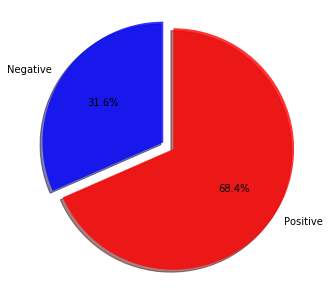

In [29]:
import matplotlib
import matplotlib.pyplot as plt

sizes = [counts['negative'], counts['positive']]
explode = (0, 0.1)
labels = 'Negative', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="br", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()